In [22]:
# This file aimed to trined on a LSTM based on different power and threshould and
# see if it works.
from DataPrepocessing import *
from NeuralNets import *
from TrainMethod import *

import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
from functools import partial


In [23]:
model = SimpleLSTM()

(612, 833)


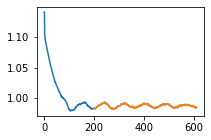

In [24]:
# read the data and only keep the stable state
plt.figure(figsize=(3,2))
raw_data_P1T1 = pd.read_csv("./data/Tracked Files/P1T1.csv")
raw_data_P1T1.fillna(0, inplace= True)
plt.plot(raw_data_P1T1.iloc[:,1])
cut_data_P1T1 = raw_data_P1T1[200:]
plt.plot(cut_data_P1T1.iloc[:,1])
print(raw_data_P1T1.shape)

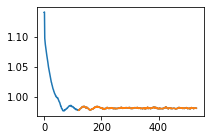

In [25]:
raw_data_P1T09 = pd.read_csv("./data/Tracked Files/P1T0.9.csv")
raw_data_P1T09.fillna(0, inplace= True)
plt.figure(figsize=(3,2))
data = raw_data_P1T09
plt.plot(data.iloc[:,1])
cut_data_P1T09 = data[120:]
plt.plot(cut_data_P1T09.iloc[:,1])

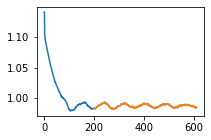

In [26]:
raw_data_P06T1 = pd.read_csv("./data/Tracked Files/P0.6T1.csv")
raw_data_P06T1.fillna(0, inplace= True)
plt.figure(figsize=(3,2))
plt.plot(raw_data_P06T1.iloc[:,1])
cut_data_P06T1 = raw_data_P06T1[200:]
plt.plot(cut_data_P06T1.iloc[:,1])

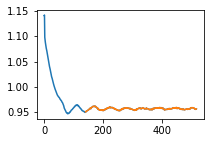

In [27]:
raw_data_P1T11 = pd.read_csv("./data/Tracked Files/P1T1.1.csv")
raw_data_P1T11.fillna(0, inplace= True)
plt.figure(figsize=(3,2))
plt.plot(raw_data_P1T11.iloc[:,1])
cut_data_P1T11 = raw_data_P1T11[140:]
plt.plot(cut_data_P1T11.iloc[:,1])

In [28]:
# now we get all the stable data
print(len(cut_data_P1T1))
print(len(cut_data_P1T11))
print(len(cut_data_P06T1))
print(len(cut_data_P1T09))

# first, cut the data according to the sequence length
sequence_length = 10

time_cut = lambda data : data[: len(data)//sequence_length * sequence_length]

cut_data_P1T11 = time_cut(cut_data_P1T11)
cut_data_P1T1 = time_cut(cut_data_P1T1)
cut_data_P06T1 = time_cut(cut_data_P06T1)
cut_data_P1T09 = time_cut(cut_data_P1T09)

# drop the first timestamp column (OR should we keep it?)

drop_first = lambda data : data.iloc[:, 1:]

cut_data_P1T11 = drop_first(cut_data_P1T11)
cut_data_P1T1 = drop_first(cut_data_P1T1)
cut_data_P06T1 = drop_first(cut_data_P06T1)
cut_data_P1T09 = drop_first(cut_data_P1T09)




print(len(cut_data_P1T1))
print(len(cut_data_P1T11))
print(len(cut_data_P06T1))
print(len(cut_data_P1T09))

412
376
412
413
410
370
410
410


In [29]:
cut_data_P06T1.columns # whether should keep the keff_relative_uncertainty

Index(['keff [/]', 'keff_relative_uncertainty [/]', 'Cs137_0 [at/b.cm]',
       'Cs137_1 [at/b.cm]', 'Cs137_2 [at/b.cm]', 'Cs137_3 [at/b.cm]',
       'Cs137_4 [at/b.cm]', 'Cs137_5 [at/b.cm]', 'Cs137_6 [at/b.cm]',
       'Cs137_7 [at/b.cm]',
       ...
       'Cs137_820 [at/b.cm]', 'Cs137_821 [at/b.cm]', 'Cs137_822 [at/b.cm]',
       'Cs137_823 [at/b.cm]', 'Cs137_824 [at/b.cm]', 'Cs137_825 [at/b.cm]',
       'Cs137_826 [at/b.cm]', 'Cs137_827 [at/b.cm]', 'Cs137_828 [at/b.cm]',
       'Cs137_829 [at/b.cm]'],
      dtype='object', length=832)

In [30]:
# this function move the keff from the first column to the last
def move_labels(df):
    # move the first column to the last column
    cols = list(df.columns)
    # df = df.iloc[:, 1:] # select all rows and columns except the first one
    df[cols[0]] = df.pop(cols[0]) # remove the first column and append it to the end
    return df


In [31]:
cut_data_P1T11 = move_labels(cut_data_P1T11)
cut_data_P1T1 = move_labels(cut_data_P1T1)
cut_data_P06T1 = move_labels(cut_data_P06T1)
cut_data_P1T09 = move_labels(cut_data_P1T09)

C:\Users\86182\AppData\Local\Temp\ipykernel_28196\3494102704.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[cols[0]] = df.pop(cols[0]) # remove the first column and append it to the end
C:\Users\86182\AppData\Local\Temp\ipykernel_28196\3494102704.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[cols[0]] = df.pop(cols[0]) # remove the first column and append it to the end
C:\Users\86182\AppData\Local\Temp\ipykernel_28196\3494102704.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result

In [32]:
cut_data_P06T1.columns

Index(['keff_relative_uncertainty [/]', 'Cs137_0 [at/b.cm]',
       'Cs137_1 [at/b.cm]', 'Cs137_2 [at/b.cm]', 'Cs137_3 [at/b.cm]',
       'Cs137_4 [at/b.cm]', 'Cs137_5 [at/b.cm]', 'Cs137_6 [at/b.cm]',
       'Cs137_7 [at/b.cm]', 'Cs137_8 [at/b.cm]',
       ...
       'Cs137_821 [at/b.cm]', 'Cs137_822 [at/b.cm]', 'Cs137_823 [at/b.cm]',
       'Cs137_824 [at/b.cm]', 'Cs137_825 [at/b.cm]', 'Cs137_826 [at/b.cm]',
       'Cs137_827 [at/b.cm]', 'Cs137_828 [at/b.cm]', 'Cs137_829 [at/b.cm]',
       'keff [/]'],
      dtype='object', length=832)

In [33]:
hist_data_P1T11 = generate_histogram(cut_data_P1T11.to_numpy())
hist_data_P1T1 = generate_histogram(cut_data_P1T1.to_numpy())
hist_data_P06T1 = generate_histogram(cut_data_P06T1.to_numpy())
hist_data_P1T09 = generate_histogram(cut_data_P1T09.to_numpy())

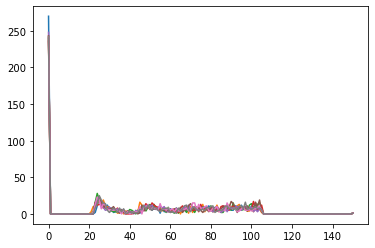

In [34]:
for i in range(1, 400,50):
    plt.plot(hist_data_P06T1[i][:])

In [35]:
print(hist_data_P06T1.shape)
print(hist_data_P1T09.shape)
print(hist_data_P1T1.shape)
print(hist_data_P1T11.shape)

(410, 151)
(410, 151)
(410, 151)
(370, 151)


In [36]:
def add_one_column (arr,new_col_value):
    # Create a new column of single value to add to the front of the array
    new_col = np.full((arr.shape[0]), new_col_value)

    # Use insert to insert the new column to the front of the array
    new_arr = np.insert(arr, 0, new_col, axis=1)

    return new_arr

def add_Power_and_Threshold(arr, p = 1, t = 1):
    arr = add_one_column(arr, p)
    arr = add_one_column(arr, t)

    return arr

In [37]:
x = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
print(add_one_column(x, 0))

[[0 1 2 3]
 [0 4 5 6]
 [0 7 8 9]]


In [38]:
# final_data_P1T11 = hist_data_P1T11
# final_data_P1T1 = hist_data_P1T1
# final_data_P06T1 = hist_data_P06T1
# final_data_P1T09 = hist_data_P1T09


final_data_P1T11 = add_Power_and_Threshold(hist_data_P1T11,1,1.1)
final_data_P1T1 = add_Power_and_Threshold(hist_data_P1T1,1,1)
final_data_P06T1 = add_Power_and_Threshold(hist_data_P06T1,0.6,1)
final_data_P1T09 = add_Power_and_Threshold(hist_data_P1T09,1,0.9)

In [39]:
print(final_data_P06T1.shape)
print(final_data_P1T1.shape)
print(final_data_P1T09.shape)
print(final_data_P1T11.shape)

(410, 153)
(410, 153)
(410, 153)
(370, 153)


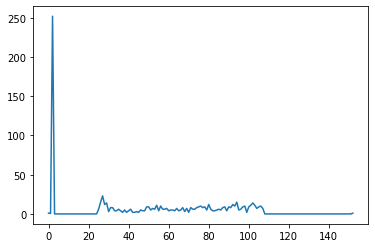

In [40]:
plt.plot(final_data_P06T1[0])

In [41]:
# the lowest is in the testing set
all_data = np.concatenate((final_data_P06T1, final_data_P1T09, final_data_P1T1,final_data_P1T11), axis=0)
# the lowest is in the training set
all_data = np.concatenate((final_data_P06T1, final_data_P1T11,final_data_P1T09, final_data_P1T1), axis=0)
print(all_data.shape)

(1600, 153)


In [42]:
# save all the data

np.savetxt('stable_data.csv', all_data, delimiter= ',')

In [43]:
raise EOFError()
# normalize the p and t

from sklearn.preprocessing import StandardScaler
# do the data preprossing
data = all_data

ss = StandardScaler()

data = ss.fit_transform(data)


clean_data = data.copy()


EOFError: 

In [ ]:
# do not normalize the p and t

# from sklearn.preprocessing import StandardScaler
# # do the data preprossing
# data = all_data[:,2:]

# ss = StandardScaler()

# data = ss.fit_transform(data)

# data = np.concatenate((all_data[:, :2], data), axis=1)


# clean_data = data.copy()

In [ ]:
data[0][0]

1.0

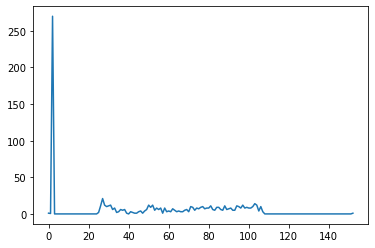

In [ ]:
plt.plot(data[1])

In [ ]:
data.shape

(1600, 153)

In [ ]:
all_data.shape

(1600, 153)

In [ ]:
training_data = ReactorData(data,10,0,0.75)
testing_data = ReactorData(data,10,0.75,1)

In [ ]:
# define neural nets

input_dim = training_data[0][0].shape[1]



# print(output_dim)

# some adjustable hyper-parameters
nets_hyper_parameters = {
'input_dim' : input_dim,
'output_dim' : 1,
'hidden_dim' : 64,
'lstm_nums_layer' : 2,
'dropout' : 0.2 
}


model = SimpleLSTM(**nets_hyper_parameters)

In [ ]:
optimizer_parameters = {
    'params':model.parameters(),
    'lr' : 0.01,
    'weight_decay' : 0.01
}

train_parameters = {
    'model' : model,
    'training_data' : training_data,
    'epoch_num': 200,
    'batch_size':16,
    'optimizer' : optim.Adam(**optimizer_parameters),
    'loss_fn' : nn.MSELoss(),
    'print_out_frequency': 20

}


model, _ = train(** train_parameters)

The loss is 0.09105089580868549 in epoch 0
The loss is 0.009946824030828107 in epoch 20
The loss is 0.005699838377938796 in epoch 40
The loss is 0.0017737562279274619 in epoch 60
The loss is 0.00041417301832822305 in epoch 80
The loss is 0.0001499376820201315 in epoch 100
The loss is 0.00011827611797887101 in epoch 120
The loss is 0.00011744905152416766 in epoch 140
The loss is 0.00011807877530573391 in epoch 160
The loss is 0.00011922623067594089 in epoch 180
Training is finished, the final loss is 0.00012041819054489717


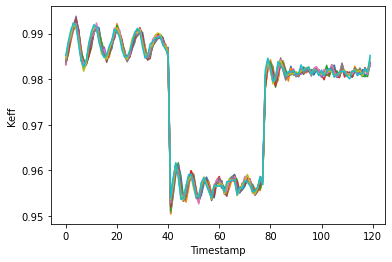

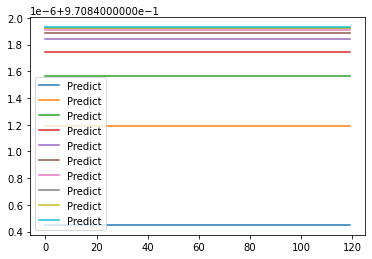

In [ ]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Assuming you have a DataSet object called 'training_set' and a trained model called 'model'
training_set = training_data
# Step 1: Create a DataLoader from your DataSet object
batch_size = 16  # Adjust this value based on your model's input requirements
train_loader = DataLoader(training_set, batch_size=batch_size, shuffle=False)

# Step 2 & 3: Iterate through the DataLoader and collect predictions and true labels
predictions = []
true_labels = []

model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient calculation
    for inputs, labels in train_loader:
        # Pass the input data to the trained model and collect the predictions
        preds = model(inputs)
        predictions.extend(preds.squeeze().tolist())
        true_labels.extend(labels.squeeze().tolist())

# Step 4: Plot the predictions and true labels for comparison
plt.figure()
plt.xlabel('Timestamp')
plt.ylabel('Keff')
plt.plot(true_labels, label="Real")
plt.figure()
plt.plot(predictions, label="Predict")
plt.legend()
plt.show()

In [ ]:
# visualize the training output
def show(data, model):
    import matplotlib.pyplot as plt


    X = (torch.tensor(data.unshaped_data.reshape(16, 10,))).double()

    y = (torch.tensor(data.unshaped_labels)).double()


    plt.figure()
    plt.xlabel('Timestamp')
    plt.ylabel('Keff')
    plt.plot(y, label = "Real")     
    plt.plot(model(X).detach().numpy(), label = "Predict")
    print(model(X).detach().numpy())
    plt.legend()


torch.Size([1200, 152])


RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 2 is not equal to len(dims) = 3

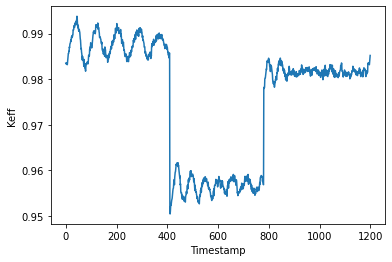

In [ ]:
show(training_data, model)

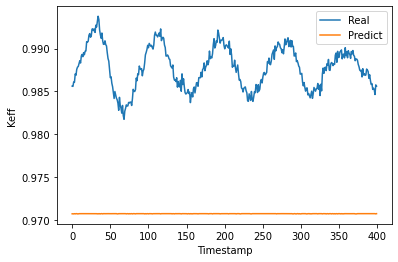

In [ ]:
show(testing_data, model)


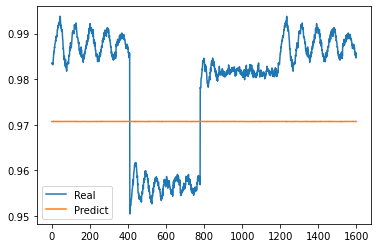

In [ ]:
# view all data together
import matplotlib.pyplot as plt


X = (torch.tensor(data[:,:-1])).double()
y = (torch.tensor(data[:,-1:])).double()


plt.figure()
plt.plot(y, label = "Real")     
plt.plot(model(X).detach().numpy(), label = "Predict")
plt.legend()

In [ ]:
# view all data in the original format
import matplotlib.pyplot as plt


X = (torch.tensor(data[:,:-1])).double()
y = (torch.tensor(data[:,-1:])).double()

# result_y = np.concatenate((X[:,2:], y), axis=1)
# result_predict = np.concatenate((X[:,2:], model(X).detach().numpy()), axis=1)

result_y = np.concatenate((X, y), axis=1)
result_predict = np.concatenate((X, model(X).detach().numpy()), axis=1)

y = ss.inverse_transform(result_y)
predict = ss.inverse_transform(result_predict)

plt.figure()
plt.ylim((0.5,1.1))
plt.plot(y[:,-1], label = "Real")     
plt.plot(predict[:,-1], label = "Predict")
plt.legend()

NameError: name 'ss' is not defined